# Creating Dataset

Desarrollar un clasificador de Rayos X de tórax Covid-19, Normal y Neumonía, como un clasificador multiclase con VGG16 y tensorflow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import visualkeras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import shutil
import random
import cv2
import argparse
import os
from PIL import ImageFont

In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 100

GPU device not found
Found GPU at: 


In [3]:
dataset_path = './dataset'

In [4]:
%%bash
rm -rf dataset
mkdir -p dataset/normal
mkdir -p dataset/pneumonia
mkdir -p dataset/new

In [5]:
covid_19_path = "../DataSet1/covid-chest-xray"
pneumonia_dataset_path ='../DataSet1/chest-xray-pneumonia/chest_xray'

## EDA of COVID Data Set

In [6]:
eda = pd.read_csv('../DataSet1/covid-chest-xray/metadata.csv')

In [7]:
eda.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


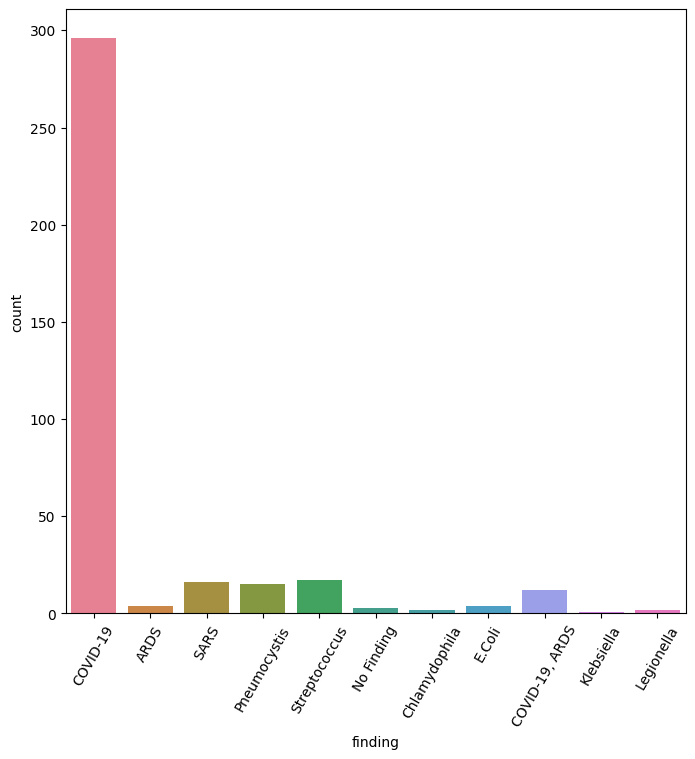

In [8]:
sns.countplot(x = 'finding', data = eda, palette = 'husl')
plt.xticks(rotation=60)
plt.savefig("Count_vs_Finding.png")
plt.show()

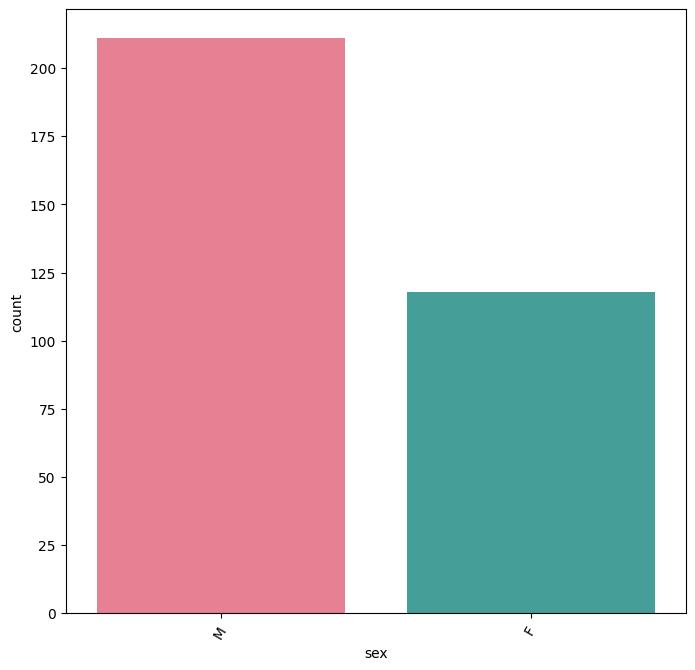

In [9]:
sns.countplot(x = 'sex', data = eda, palette = 'husl')
plt.xticks(rotation=60)
plt.savefig("Count_vs_Sex.png")
plt.show()

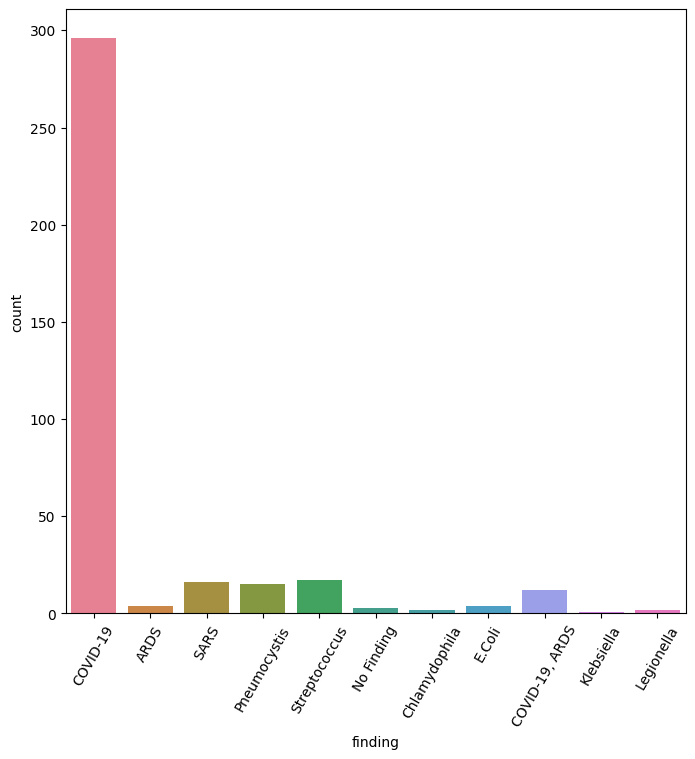

In [10]:
sns.countplot(x = 'finding', data = eda, palette = 'husl')
plt.xticks(rotation=60)
plt.savefig("Count_vs_Finding.png")
plt.show()

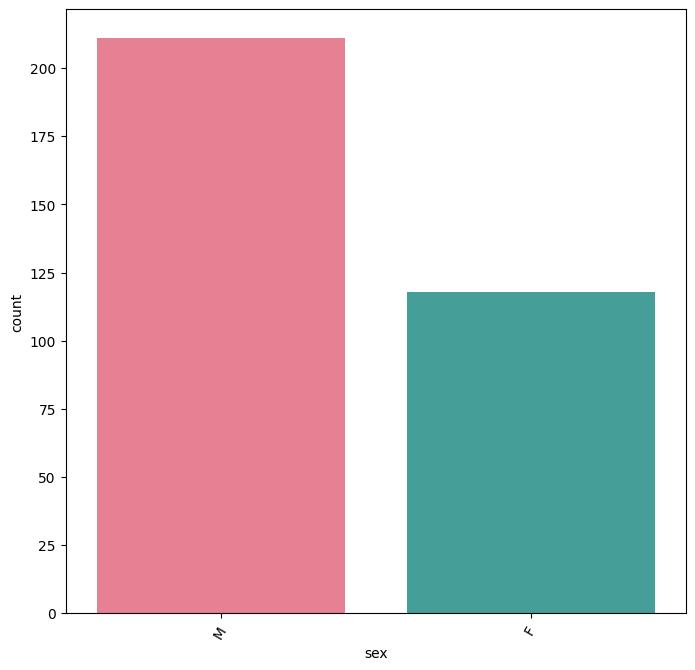

In [11]:
sns.countplot(x = 'sex', data = eda, palette = 'husl')
plt.xticks(rotation=60)
plt.savefig("Count_vs_Sex.png")
plt.show()

# Creating Dataset

In [12]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_19_path, "metadata.csv"])
df = pd.read_csv(csvPath)

In [13]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))
samples = 146

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [14]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "PNEUMONIA"])
imagePaths = list(paths.list_images(basePath))
samples = 146

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/pneumonia", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

# X-ray show

In [15]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)
    plt.savefig(maintitle.replace(" ", "_") + ".png")

normal_images = list(paths.list_images(f"{dataset_path}/normal"))
pneumonia_images = list(paths.list_images(f"{dataset_path}/pneumonia"))

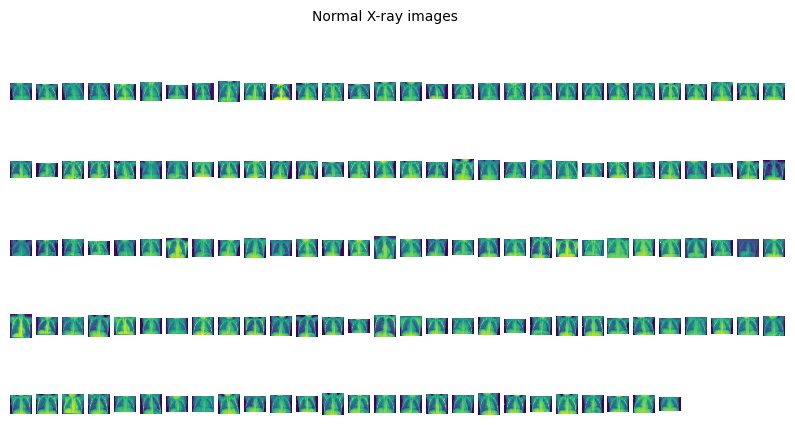

In [16]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

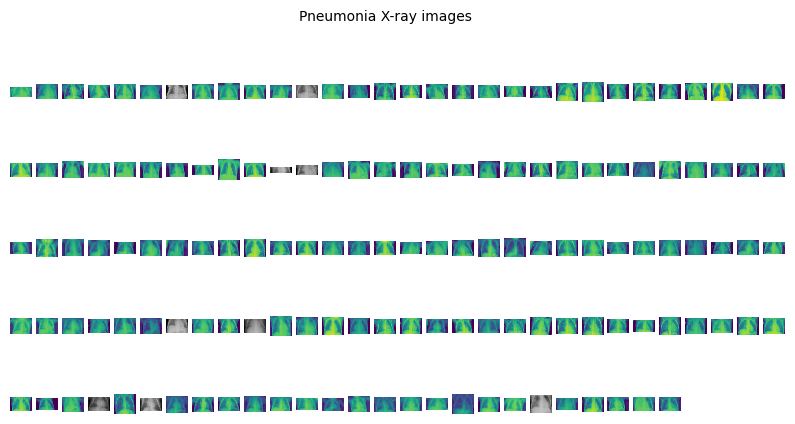

In [17]:
plots_from_files(pneumonia_images, rows=5, maintitle="Pneumonia X-ray images")

# Data Preprocesing

In [18]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 100
BS = 8

In [19]:
# lets take the labels of each image in the directory to make a classfication
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)
print("[INFO] Images successfully loaded")

[INFO] loading images...
[INFO] Images successfully loaded


In [20]:
# Now we will create a One-Hot encoding to the list of labels to make the classfication
# integer encode
lb_encoder = LabelEncoder()
labels = lb_encoder.fit_transform(labels)
labels = to_categorical(labels)


# Split the data into training and testing using the 80% of training and 20% to testing
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, stratify = labels,random_state = 42)


# Set the image augmentation of the training data
trainAug = ImageDataGenerator(rotation_range= 15, fill_mode='nearest')

# Making the model VGG16

In [21]:
base_model = VGG16(weights = 'imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
headmodel = base_model.output
headmodel = AveragePooling2D(pool_size =(4, 4))(headmodel)
headmodel = Flatten(name ='Flatten')(headmodel)
headmodel = Dense(64, activation = 'relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = base_model.input, outputs = headmodel)

for layers in base_model.layers:
    layers.trainable = False


opt = Adam(lr = INIT_LR, decay = INIT_LR/EPOCHS)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

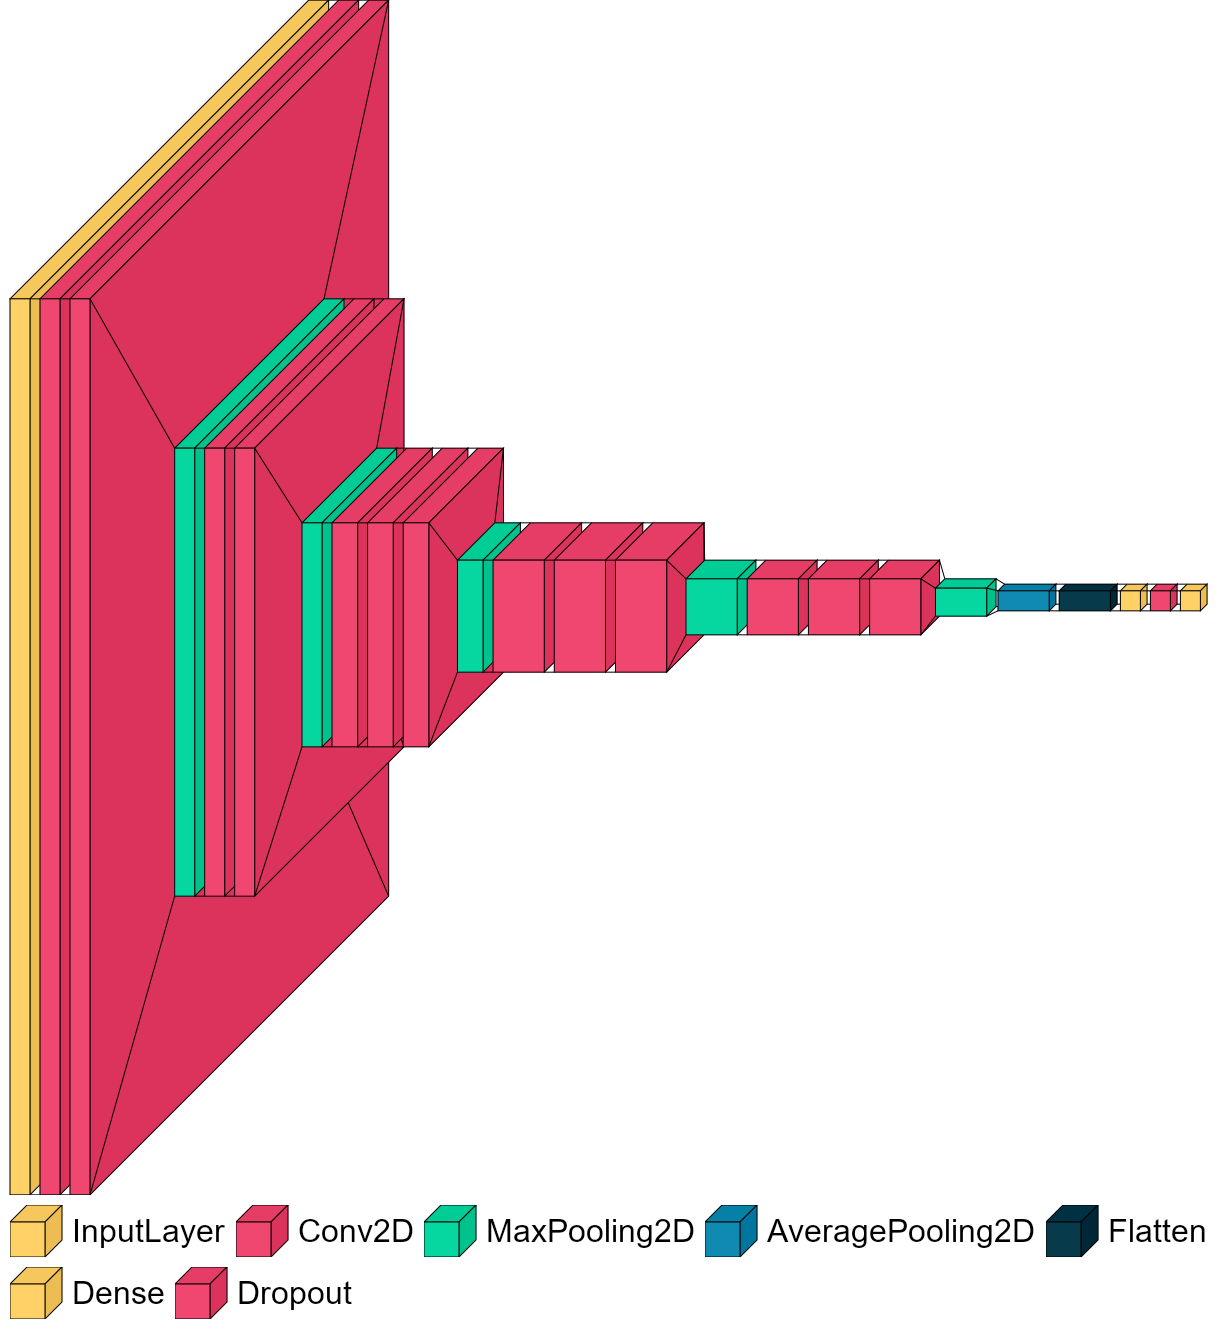

In [57]:
font = ImageFont.truetype("arial.ttf", 32)
visualkeras.layered_view(model, to_file='layered_view.png', font=font, legend=True)

In [24]:
# training the model with gpu or cpu, it depends:
with tf.device('/gpu:0'):
    print("Training the model with gpu . . .")
    training = model.fit(trainAug.flow(X_train, y_train, batch_size = BS),steps_per_epoch=len(X_train) // BS, validation_data=(X_test, y_test), validation_steps=len(X_test) // BS, epochs=100)

#with tf.device('/cpu:0'):
#    print("Training the model with cpu . . .")
#    training = model.fit_generator(trainAug.flow(X_train, y_train, batch_size = BS),steps_per_epoch=len(X_train) // BS, validation_data=(X_test, y_test), validation_steps=len(X_test) // BS, epochs=100)

Training the model with gpu . . .
Epoch 1/100
29/29 [==============================] - 22s 763ms/step - loss: 0.7539 - accuracy: 0.4936 - val_loss: 0.6296 - val_accuracy: 0.7966
Epoch 2/100
29/29 [==============================] - 23s 795ms/step - loss: 0.6260 - accuracy: 0.6380 - val_loss: 0.5834 - val_accuracy: 0.7627
Epoch 3/100
29/29 [==============================] - 24s 818ms/step - loss: 0.5696 - accuracy: 0.7327 - val_loss: 0.5261 - val_accuracy: 0.8305
Epoch 4/100
29/29 [==============================] - 23s 792ms/step - loss: 0.4980 - accuracy: 0.8114 - val_loss: 0.4950 - val_accuracy: 0.7627
Epoch 5/100
29/29 [==============================] - 23s 797ms/step - loss: 0.4714 - accuracy: 0.8282 - val_loss: 0.4571 - val_accuracy: 0.8475
Epoch 6/100
29/29 [==============================] - 24s 828ms/step - loss: 0.4214 - accuracy: 0.8703 - val_loss: 0.4482 - val_accuracy: 0.7797
Epoch 7/100
29/29 [==============================] - 24s 830ms/step - loss: 0.4075 - accuracy: 0.8694 

29/29 [==============================] - 25s 877ms/step - loss: 0.1386 - accuracy: 0.9600 - val_loss: 0.3588 - val_accuracy: 0.8814
Epoch 58/100
29/29 [==============================] - 26s 888ms/step - loss: 0.1046 - accuracy: 0.9681 - val_loss: 0.3645 - val_accuracy: 0.8814
Epoch 59/100
29/29 [==============================] - 25s 882ms/step - loss: 0.1048 - accuracy: 0.9667 - val_loss: 0.3755 - val_accuracy: 0.8814
Epoch 60/100
29/29 [==============================] - 26s 897ms/step - loss: 0.1339 - accuracy: 0.9585 - val_loss: 0.3699 - val_accuracy: 0.8814
Epoch 61/100
29/29 [==============================] - 25s 860ms/step - loss: 0.1251 - accuracy: 0.9459 - val_loss: 0.3803 - val_accuracy: 0.8814
Epoch 62/100
29/29 [==============================] - 26s 902ms/step - loss: 0.1437 - accuracy: 0.9380 - val_loss: 0.3792 - val_accuracy: 0.8814
Epoch 63/100
29/29 [==============================] - 25s 865ms/step - loss: 0.0953 - accuracy: 0.9636 - val_loss: 0.3746 - val_accuracy: 0.864

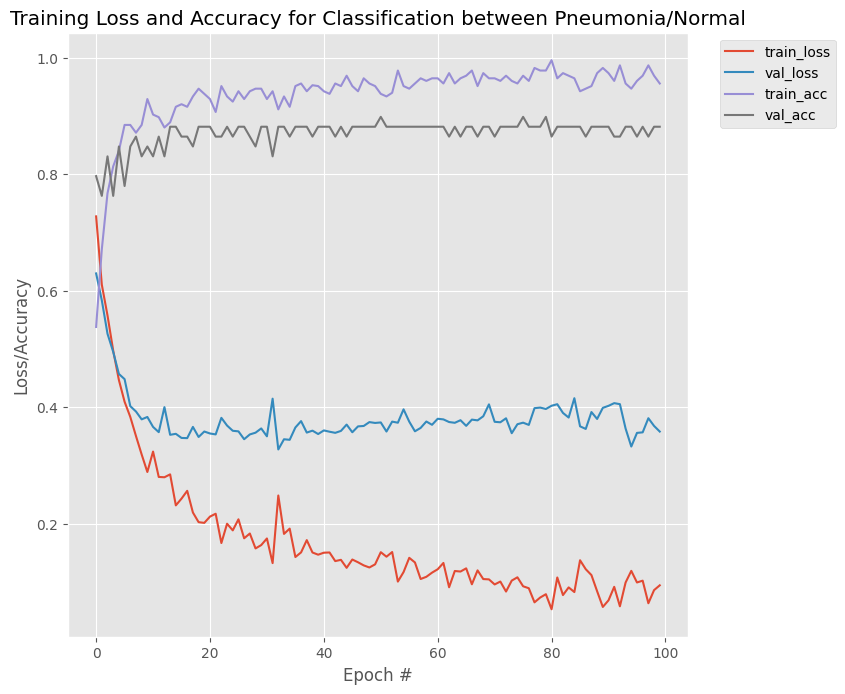

In [58]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N), training.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), training.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), training.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), training.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy for Classification between Pneumonia/Normal")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.savefig("Loss_and_Accuracy.png")

## Save model

In [26]:
model.save("VGG16_Covid19_Normal_Neumonia.h5")

# Evaluting the model

In [27]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs, target_names=lb_encoder.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

      normal       0.89      0.86      0.88        29
   pneumonia       0.87      0.90      0.89        30

    accuracy                           0.88        59
   macro avg       0.88      0.88      0.88        59
weighted avg       0.88      0.88      0.88        59



In [28]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the accuracy, sensitivity, and specificity of the test
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

accuracy: 0.8814
sensitivity: 0.8621
specificity: 0.9000


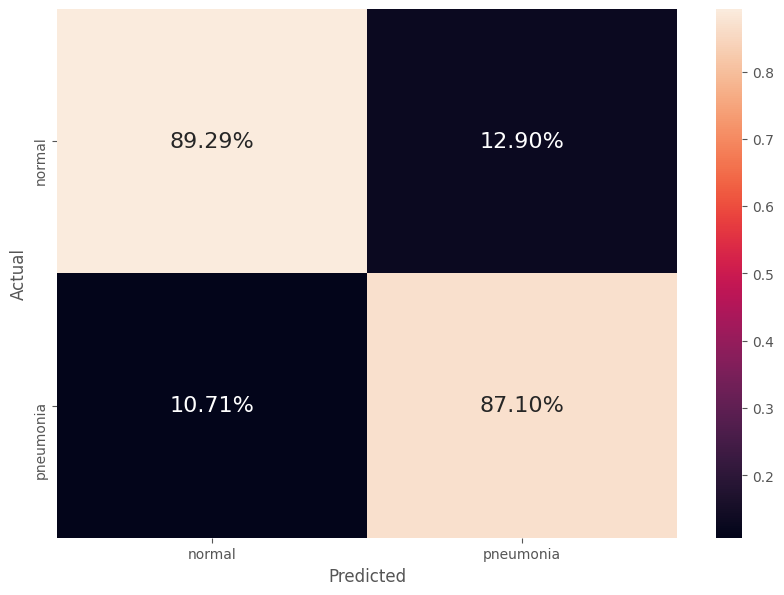

In [29]:
df_cm= pd.DataFrame(cm, columns=lb_encoder.classes_, index=lb_encoder.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(df_cm/np.sum(df_cm), fmt='.2%', annot = True, annot_kws={'size':16})
plt.savefig("Actual_vs_Predicted.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

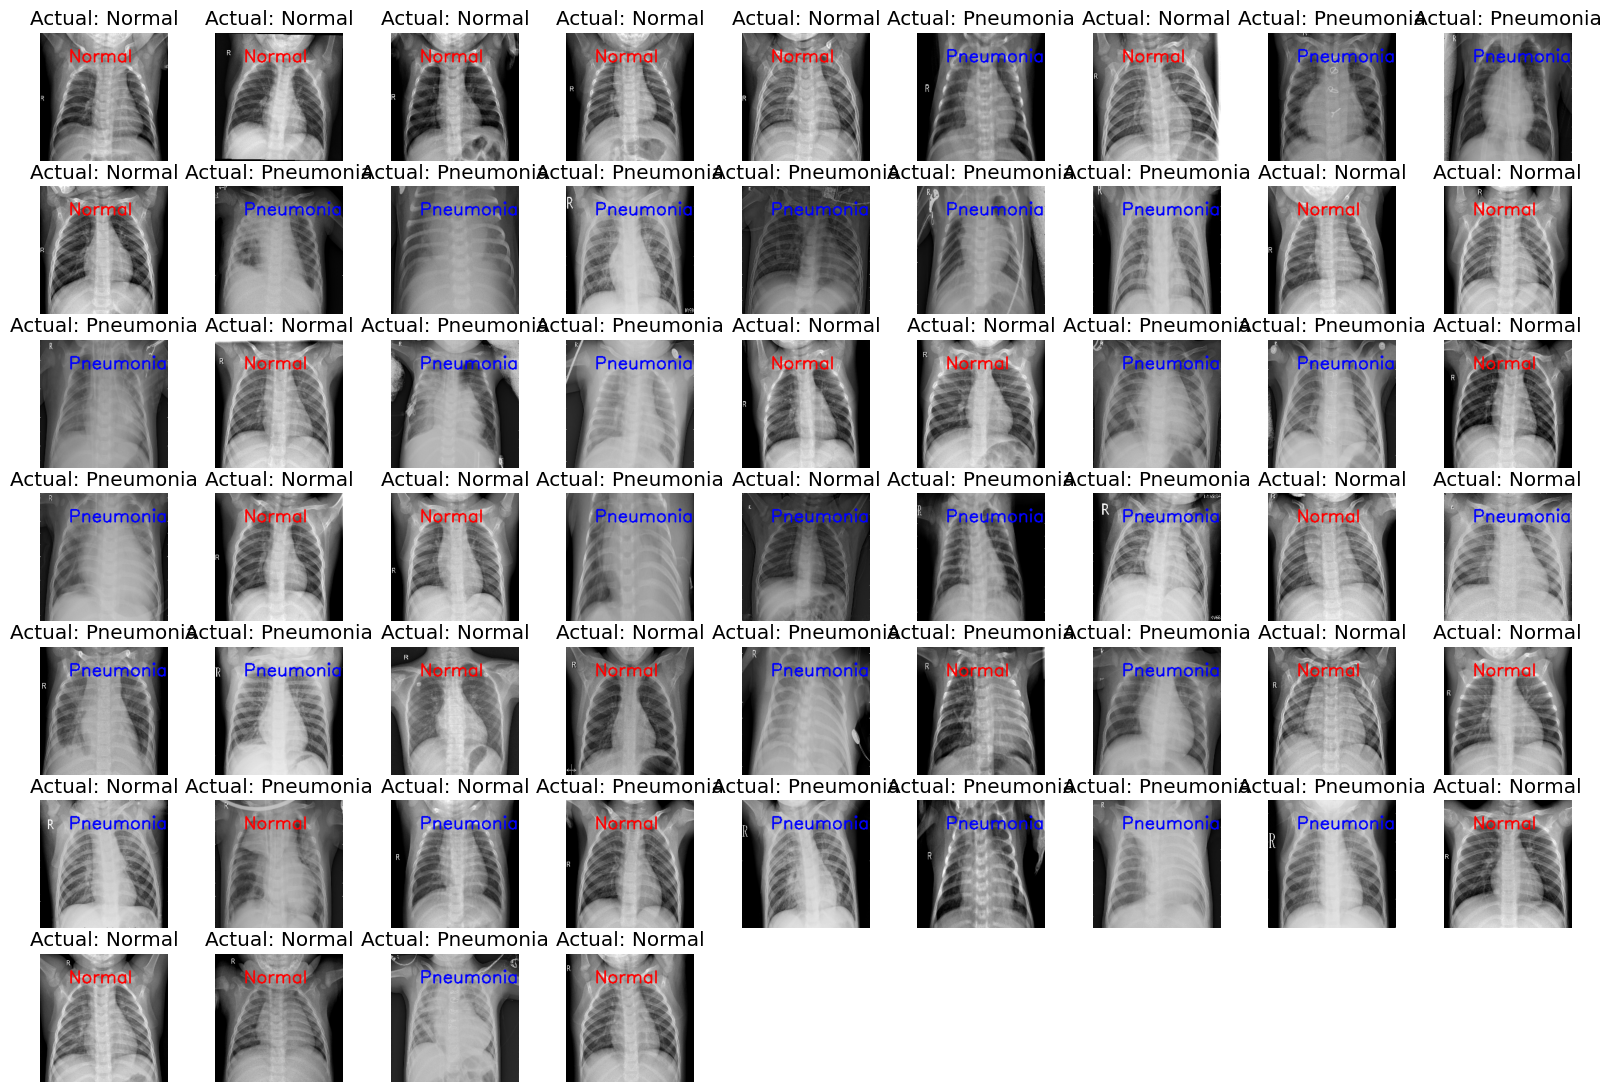

In [42]:
rows = 10
columns = 9
fig = plt.figure(figsize=(20, 20))
for m in range(1, 59):
    if str(lb_encoder.inverse_transform(predIdxs)[m-1]) == "normal":
        text = "Normal"
        color = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(predIdxs)[m-1]) == "pneumonia":
        text = "Pneumonia"
        color = (0, 0, 255)
        
    if str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == "normal":
        text2 = "Normal"
        color2 = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == "pneumonia":
        text2 = "Pneumonia"
        color2 = (0, 0, 255)
    img = X_test[m-1].copy()
    # Window name in which image is displayed 
    window_name = text
  
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    org = (50, 50) 
  
    # fontScale 
    fontScale = 1
  
    # Line thickness of 2 px 
    thickness = 2
    img = cv2.putText(img, text, org, font,
                      fontScale, color, thickness, cv2.LINE_AA)
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.title("Actual: " + text2)
    plt.axis('off')
    if m == 58:
        plt.savefig("./Results1.png")
plt.show()

# Trying with new images in different database ("covid19-radiography-database")

In [49]:
new_dataset ='../DataSet1/covid19-radiography-database/COVID-19_Radiography_Dataset'

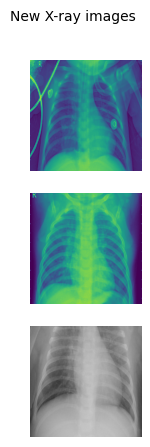

In [50]:
basePath = os.path.sep.join([new_dataset, "PNEUMONIA"])
imagePaths = list(paths.list_images(basePath))
samples = 3

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/new", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

new_images = list(paths.list_images(f"{dataset_path}/new"))
plots_from_files(new_images, rows=3, maintitle="New X-ray images")

In [53]:
new_data = []
for imagePath in imagePaths:
    new_image = cv2.imread(imagePath)
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    new_image = cv2.resize(new_image, (224, 224))
    # update the data and labels lists, respectively
    new_data.append(new_image)

new_data = np.array(new_data) / 255.0
new_data.shape

(3, 224, 224, 3)

In [54]:
# make new predictions:
print("[INFO] Making new predictions...")
new_pred = model.predict(new_data, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
new_pred = np.argmax(new_pred, axis=1)

[INFO] Making new predictions...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO] printing new images with their classification


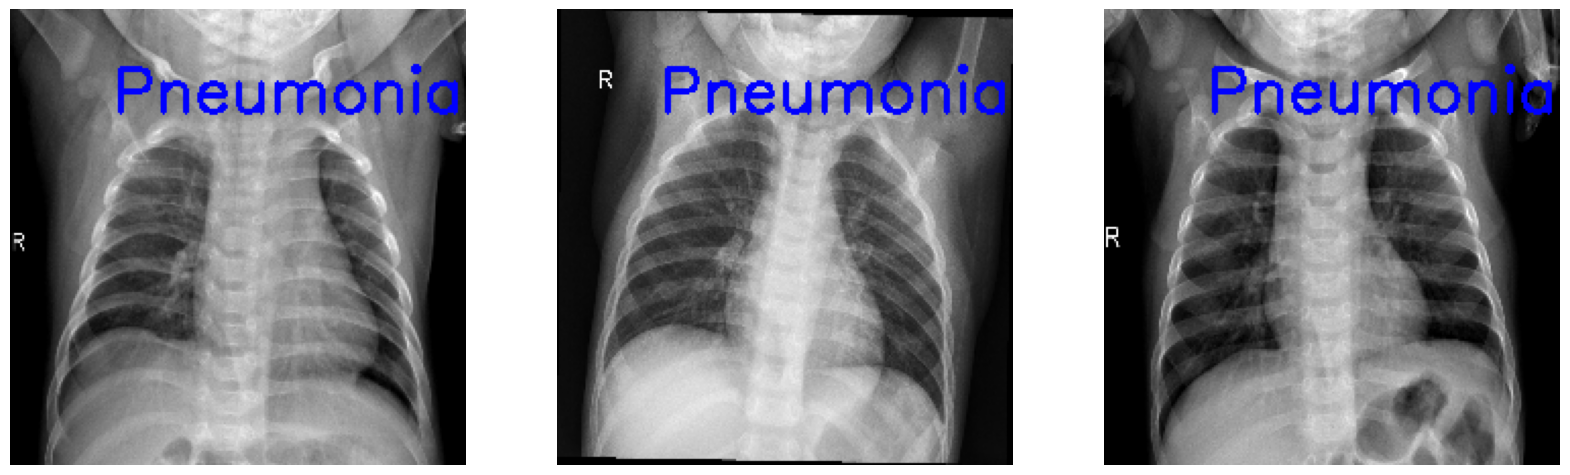

In [55]:
print("[INFO] printing new images with their classification")
rows = 1
columns = 3
fig = plt.figure(figsize=(20, 20))
for m in range(1, 4):
    if str(lb_encoder.inverse_transform(new_pred)[m-1]) == "normal":
        text = "Normal"
        color = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(new_pred)[m-1]) == "pneumonia":
        text = "Pneumonia"
        color = (0, 0, 255)
    img = X_test[m-1].copy()
    # Window name in which image is displayed 
    window_name = text
  
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    org = (50, 50) 
  
    # fontScale 
    fontScale = 1
  
    # Line thickness of 2 px 
    thickness = 2
    img = cv2.putText(img, text, org, font,
                      fontScale, color, thickness, cv2.LINE_AA)
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.axis('off')
    if m == 3:
        plt.savefig("./Results2.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO] Making new prediction...
[INFO] printing new image with its classification


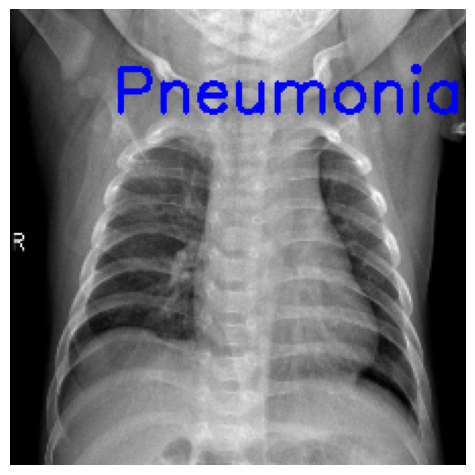

In [56]:
new_data2 = []

# Making some new testing for a specific image in the file:
new_imag2 = cv2.imread('../DataSet1/covid19-radiography-database/COVID-19_Radiography_Dataset/PNEUMONIA/Viral Pneumonia-17.png')
new_imag2 = cv2.cvtColor(new_imag2, cv2.COLOR_BGR2RGB)
new_imag2 = cv2.resize(new_imag2, (224,224))
new_data2.append(new_imag2)

new_data2 = np.array(new_data2)/255.0

# make new prediction
print("[INFO] Making new prediction...")
new_pred2 = model.predict(new_data2, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
new_pred2 = np.argmax(new_pred2, axis=1)

print("[INFO] printing new image with its classification")
rows = 1
columns = 3
fig = plt.figure(figsize=(20, 20))
for m in range(1, 2):
    if str(lb_encoder.inverse_transform(new_pred2)[m-1]) == "normal":
        text = "Normal"
        color = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(new_pred2)[m-1]) == "pneumonia":
        text = "Pneumonia"
        color = (0, 0, 255)
    img = X_test[m-1].copy()
    # Window name in which image is displayed 
    window_name = text
  
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # org 
    org = (50, 50) 
  
    # fontScale 
    fontScale = 1
  
    # Line thickness of 2 px 
    thickness = 2
    img = cv2.putText(img, text, org, font,
                      fontScale, color, thickness, cv2.LINE_AA)
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.axis('off')
    if m == 1:
        plt.savefig("./Results3.png")
plt.show()